# Neural Collaborative Based Filtering

- using neural network to learn the user-item interaction

This piece is a TensorFlow implementation of Neural Collaborative Filtering (NCF) from the paper [He et al. (2017)](https://arxiv.org/pdf/1708.05031.pdf).

## Summary

NCF uses neural networks to model the interactions between users and items. NCF replaces the inner product (used in ordinary MF methods) with a neural architecture that can learn an arbitrary function from data. This allows NCF to express and generalize matrix factorization under its framework. Essentially, it uses a neural network to learn the user-item interaction function, and uses the learned function to predict the corresponding rating. A multi-layer perceptron is used to learn the user-item interaction function. 


## Model 1: Ratings Only

The steps are as follows:

1. Read in Original Data
2. Remove some ratings to create the test set
3. With remaining ratings, create training set
4. Preprocess the data (melt the data, create user and item indices, normalize the ratings)
5. Create neural network model (NCF)
6. Train the model
7. Hyperparameter tuning
8. Evaluate the model on the test set
9. Gather all ratings prediction metrics (MAE, MSE, RMSE)

In [78]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# tensorflow libraries load
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [79]:
# load data
amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set3_data_modelling.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))
print('Min number of ratings per user: ', amz_data['reviewerID'].value_counts().min())
print('Max number of ratings per user: ', amz_data['reviewerID'].value_counts().max())
print('Min number of ratings per product: ', amz_data['asin'].value_counts().min())
print('Max number of ratings per product: ', amz_data['asin'].value_counts().max())


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())


,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249
Min number of ratings per user:  13
Max number of ratings per user:  193
Min number of ratings per product:  13
Max number of ratings per product:  189


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating Train and Test Sets

In [80]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating
24,A119Q9NFGVOEJZ,0767834739,5.0
39,A120UTHQDQIJGH,0767834739,1.0
157,A169I83JL8QJGN,0767834739,1.0
333,A1COW0UIB5HA9J,0767834739,5.0


Data is in format: user, product, rating, text embeddings.
It is ready to be partitioned into training and testing sets.


In [81]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product
24,24,0
39,39,0
157,157,0



Testing Data


,user,product
174,174,0
4473,805,1
4869,1201,1


### Creating NCF Model

Inputs:
user_input and product_input: These are integer inputs representing user and product IDs.
user_embedding and product_embedding: These layers create dense embeddings for users and products based on their IDs.
user_vecs and product_vecs: These flatten the embeddings to create feature vectors.
input_vecs: The concatenated feature vectors serve as the input to the neural network.
Neural Network Architecture:
You’ve designed a feedforward neural network with multiple layers.
The first layer (i == 0) has n_nodes neurons, followed by dropout regularization.
Subsequent layers reduce the number of neurons by halving n_nodes.
The final output layer predicts the rating (regression task).
Optimizers:
You’ve implemented three optimizers: Adam, SGD, and RMSprop.
The choice of optimizer affects how the model updates its weights during training.
Loss Function:
The mean squared error (MSE) loss is used for regression tasks.
The model aims to minimize the difference between predicted and actual ratings.
Training:
The model is trained using user and product IDs as input features.
The train_x dictionary contains user and product data.
The train_y array holds the corresponding ratings.
You’ve split the data into training and validation sets (10% validation split).

In [82]:
# Function to train a neural network model for collaborative filtering
def train_model_1(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, seed=2207, train_plot=True):
    """
    Function to train a neural network model for collaborative filtering.
    :param n_layers: Number of dense layers in the model
    :param n_nodes: Number of nodes in each dense layer
    :param optimizer: Optimizer to use for training
    :param epochs: Number of epochs to train for
    :param learning_rate: Learning rate for the optimizer
    :param train_x: Training data
    :param train_y: Training labels
    :param seed: Random seed
    :return: Trained model and training history
    """
    # Set random seed
    np.random.seed(seed)

    # Create user and product embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, product_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, product_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_1.pdf")
        plt.show()
    
    return model, history

### Training NCF Model

In [84]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_1(n_layers=2, n_nodes=512, optimizer='adam', epochs=2, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model2, history2 = train_model_1(n_layers=3, n_nodes=512, optimizer='adam', epochs=2, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model3, history3 = train_model_1(n_layers=4, n_nodes=512, optimizer='adam', epochs=2, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model4, history4 = train_model_1(n_layers=5, n_nodes=512, optimizer='adam', epochs=2, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/2
1015/1015 [==============================] - 15s 15ms/step - loss: 0.0571 - val_loss: 0.0476
Epoch 2/2
1015/1015 [==============================] - 12s 12ms/step - loss: 0.0427 - val_loss: 0.0492
Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/2
1015/1015 [==============================] - 34s 33ms/step - loss: 0.0594 - val_loss: 0.0521
Epoch 2/2
1015/1015 [==============================] - 31s 30ms/step - loss: 0.0440 - val_loss: 0.0498
Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/2
1015/1015 [==============================] - 33s 31ms/step - loss: 0.0653 - val_loss: 0.0470
Epoch 2/2
1015/1015 [==============================] - 32s 31ms/step - loss: 0.0459 - val_loss: 0.0499
Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/2
1015/1015 [=============================

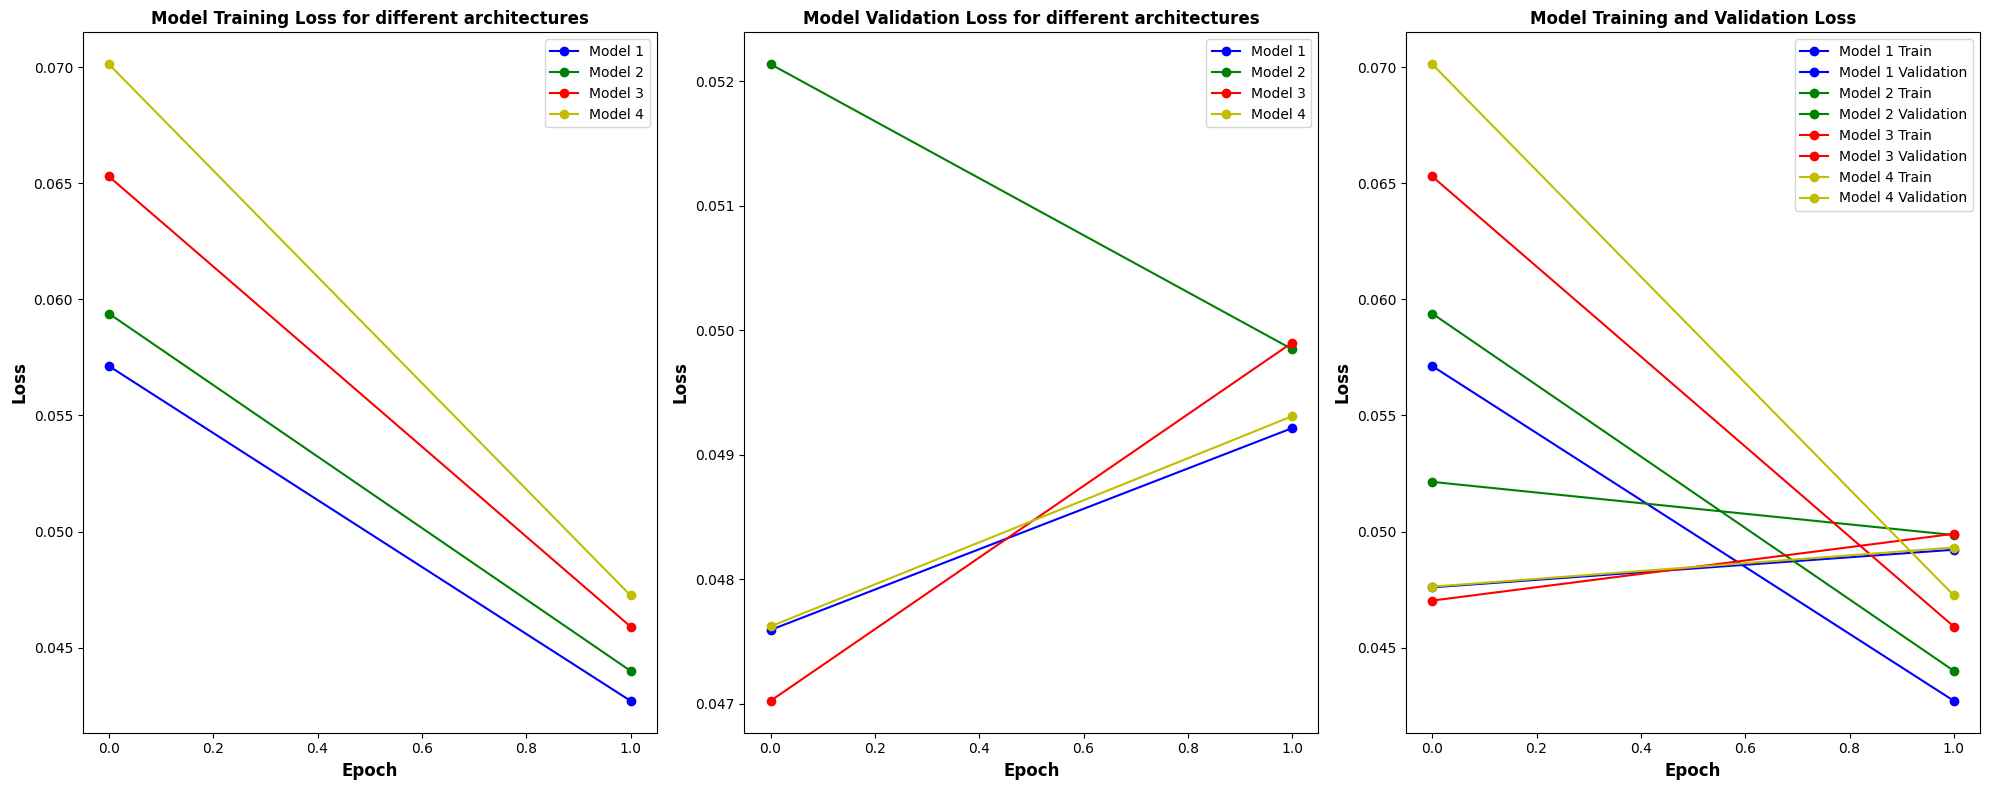

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [85]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_amz_1.pdf")
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")


### Hyperparameter Tuning / Grid Search

In [87]:
import itertools

# Grid Search Parameters
n_layers = [2] # , 3, 6
n_nodes = [512] # , 1024
optimizer = ['adam'] # , 'sgd', 'rmsprop'
epochs = [1] # 50, 100
learning_rate = [0.001] # , 0.01, 0.1
batch_size = [64] # , 128
print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs = combination

        # Train the model
        model, history = train_model_1(n_layer, n_node, opt, epoch, lr, bs, train_x, train_y, train_plot=False)

        # Evaluate the model
        loss = history.history['val_loss'][-1]  # Considering only the last value

        # Check if this model is better than the previous best
        if best_score is None or loss < best_score:
            best_score = loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y)
print(f"Best Parameters: {best_params}")

Number of combinations: 1
1015/1015 [==============================] - 19s 18ms/step - loss: 0.0574 - val_loss: 0.0501
Best Parameters: (2, 512, 'adam', 1, 0.001, 64)


1015/1015 [==============================] - 15s 14ms/step - loss: 0.0571 - val_loss: 0.0503


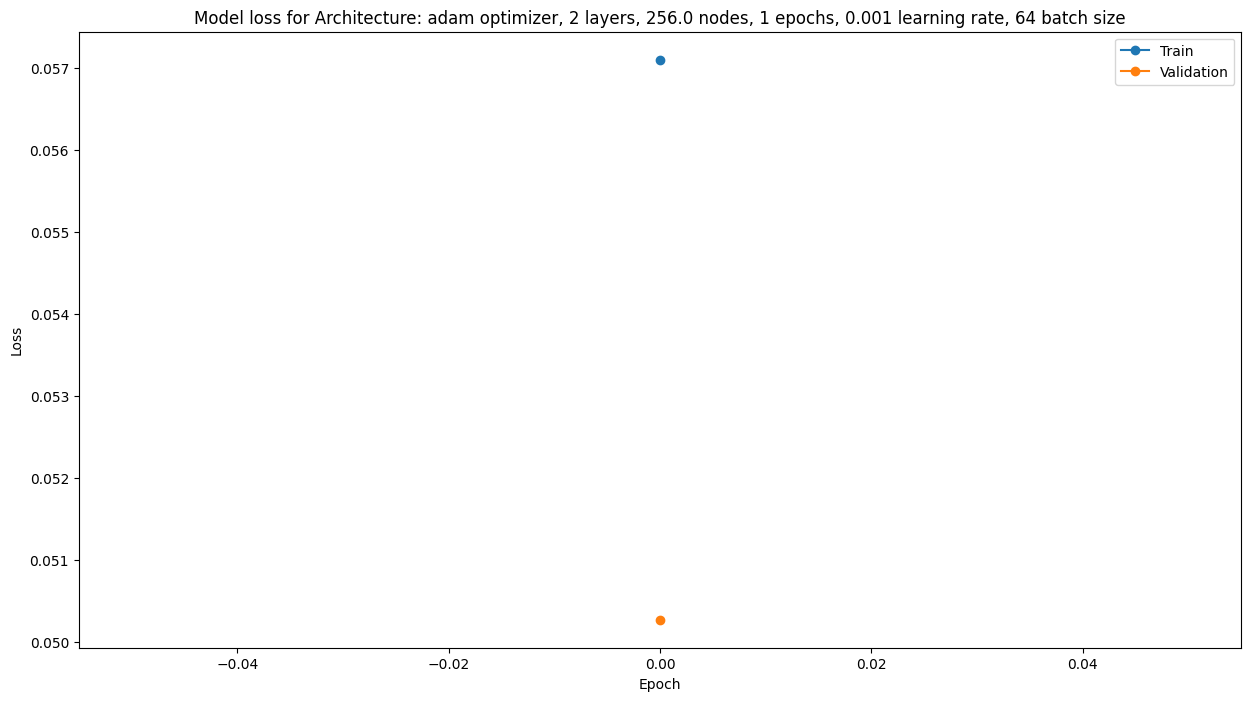

In [88]:
# fit best model 
best_model, history = train_model_1(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], train_x=train_x, train_y=train_y, train_plot=True)

### Evaluating NCF Model

In [94]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\NCF_results_1.csv", index=False)
results

344/344 [==============================] - 2s 6ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.6612423530430067
Mean Squared Error (MSE): 0.8104782903340909
Root Mean Squared Error (RMSE): 0.9002656776386018


,MAE,MSE,RMSE
0,0.661,0.81,0.9


## Model 2: Ratings + Reviews

In [96]:
# load data
amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set3_data_modelling.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

- https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true

In [24]:
import tensorflow as tf
import tensorflow_hub as hub

# load the model for sentence embeddings
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
sent_model = hub.load(module_url)
print(f"Module {module_url} loaded")

# Embedding review text
print("Applying the Universal Sentence Encoder on the review text...")
review_text = amz_data['reviewText']  # Replace with your actual column name
text_embeddings = sent_model(review_text)
print("Review text embeddings generated!")
print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# attach embeddings to dataframe
text_embeddings = text_embeddings.numpy()
text_embeddings = pd.DataFrame(text_embeddings)
text_embeddings['revText'] = amz_data['reviewText']
text_embeddings['asin'] = amz_data['asin']
text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

Module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
Applying the Universal Sentence Encoder on the review text...
Review text embeddings generated!
Shape of Text Embeddings: (10000, 512)


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,0.008073,-0.067272,0.054706,0.023007,0.024579,0.050034,-0.065852,0.067248,0.056147,0.062951,...,0.049765,-0.016111,-0.059012,0.024718,-0.051251,-0.011736,0.000867,even though i use dreamweaver a great deal and...,0321719816,A14638TGYH7GD9
1,-0.001283,-0.068478,0.021437,0.039280,0.002183,0.070368,-0.023990,0.078988,0.043503,0.062656,...,0.070095,-0.042620,0.007568,0.004445,-0.045245,-0.036236,0.042330,i spent several hours on the lesson and i love...,0321719816,A2JMJVNTBL7K7E
2,0.038584,-0.082029,0.064245,-0.025187,0.015820,0.072616,-0.034404,0.097009,0.085545,0.039091,...,0.060228,-0.015527,-0.008636,-0.002517,0.010856,0.043800,0.010278,the video is wellpaced and delivered in an und...,0321719816,A2BVNVJOFXGZUB
3,0.031828,-0.067494,0.063483,0.006458,-0.042029,0.037749,-0.045193,0.061837,0.065983,0.055801,...,0.063073,-0.060632,-0.006769,0.019594,0.000966,-0.063385,-0.039714,i have had dreamweaver mx2004 since it came ou...,0321719816,A14JBDSWKPKTZA


#### Training and Test Sets

In [25]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 1

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
2971,A16QODENBJVUI1,0763855553,5.0,-0.025630,-0.061428,-0.050270,0.056115,0.025042,-0.006502,0.048127,...,-0.056834,-0.061576,-0.000995,-0.040687,-0.053835,0.002773,-0.000159,0.001383,-0.061306,0.046232
3124,A1EMDSTJDUE6B0,0763855553,3.0,0.043199,-0.048677,-0.039383,0.034834,0.015199,-0.010999,-0.014935,...,0.032779,-0.063053,-0.046424,0.007785,0.073428,0.021332,-0.020626,-0.018779,-0.039079,0.050754
3179,A1GQRGB8FGSLIZ,0763855553,3.0,-0.055504,-0.059009,-0.042365,0.010823,0.032200,0.022924,0.052965,...,-0.058867,-0.059034,0.050042,-0.052651,-0.059034,-0.012173,0.047237,0.055649,-0.057172,0.051605
4491,A376OJHLE6SU9Q,0763855553,4.0,-0.005793,-0.041129,-0.053105,-0.018533,0.022194,-0.011605,0.017973,...,-0.073255,-0.080659,-0.023402,-0.030057,-0.077253,-0.040100,-0.011489,0.033571,-0.060586,0.047489


Data is in format: user, product, rating, text embeddings.
It is ready to be partitioned into training and testing sets.


In [6]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]


# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
2971,72,0,-0.025630,-0.061428,-0.050270,0.056115,0.025042,-0.006502,0.048127,0.041273,...,-0.056834,-0.061576,-0.000995,-0.040687,-0.053835,0.002773,-0.000159,0.001383,-0.061306,0.046232
3124,139,0,0.043199,-0.048677,-0.039383,0.034834,0.015199,-0.010999,-0.014935,-0.018428,...,0.032779,-0.063053,-0.046424,0.007785,0.073428,0.021332,-0.020626,-0.018779,-0.039079,0.050754
3179,171,0,-0.055504,-0.059009,-0.042365,0.010823,0.032200,0.022924,0.052965,0.010663,...,-0.058867,-0.059034,0.050042,-0.052651,-0.059034,-0.012173,0.047237,0.055649,-0.057172,0.051605



Testing Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,98,0,0.008073,-0.067272,0.054706,0.023007,0.024579,0.050034,-0.065852,0.067248,...,-0.012790,-0.068034,0.021810,0.049765,-0.016111,-0.059012,0.024718,-0.051251,-0.011736,0.000867
1,105,0,0.031828,-0.067494,0.063483,0.006458,-0.042029,0.037749,-0.045193,0.061837,...,-0.056906,-0.067767,-0.027785,0.063073,-0.060632,-0.006769,0.019594,0.000966,-0.063385,-0.039714
2,1040,0,0.038584,-0.082029,0.064245,-0.025187,0.015820,0.072616,-0.034404,0.097009,...,0.039041,-0.095472,-0.040151,0.060228,-0.015527,-0.008636,-0.002517,0.010856,0.043800,0.010278


#### NCF Model with Reviews


**Inputs:**
You have three input layers:
- `user_input`: Represents the user ID (integer).
- `product_input`: Represents the product ID (integer).
- `text_input`: Represents the text embeddings of user reviews (float32).

**Embeddings:**
You create embeddings for users and products using the Embedding layer. These embeddings are essential for capturing latent features.
- `user_embedding`: Embedding for user IDs.
- `product_embedding`: Embedding for product IDs.

**Flattening and Concatenation**:
You flatten the user and product embeddings to create vectors (`user_vecs` and `product_vecs`).
Then, you concatenate these vectors with the text embeddings (`text_input`) to form the combined input vector (`input_vecs`).

**Hidden Layers:**
You use a loop to create hidden layers:
For the first layer (i == 0), you apply a Dense layer with ReLU activation and dropout.
For subsequent layers, you reduce the number of nodes by half and apply the same architecture.

**Output Layer**:
The final output layer (*y*) predicts the user-item interaction (*rating*).

**Model Compilation**:
You compile the model using the specified optimizer (Adam, SGD, or RMSprop) and the mean squared error (MSE) loss.

**Training:**
The model is trained using user and product data (`train_x['user']` and `train_x['product']`) along with the target variable (`train_y`).
You split the data into training and validation sets (10% validation split).

**Return:**
The function returns the trained model and training history.

In [26]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_2(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, text_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, text_input], outputs=y)
    # ...
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 2:]], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_2.pdf")
        plt.show()
    
    return model, history


In [27]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_2(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512,  seed=10, train_plot=False)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model2, history2 = train_model_2(n_layers=3, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

# Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model3, history3 = train_model_2(n_layers=4, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

# Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model4, history4 = train_model_2(n_layers=5, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


Epoch 1/50
102/102 [==============================] - 3s 17ms/step - loss: 0.0626 - val_loss: 0.0491
Epoch 2/50
102/102 [==============================] - 1s 12ms/step - loss: 0.0331 - val_loss: 0.0511
Epoch 3/50
102/102 [==============================] - 1s 12ms/step - loss: 0.0276 - val_loss: 0.0457
Epoch 4/50
102/102 [==============================] - 1s 13ms/step - loss: 0.0230 - val_loss: 0.0465
Epoch 5/50
102/102 [==============================] - 1s 12ms/step - loss: 0.0178 - val_loss: 0.0436
Epoch 6/50
102/102 [==============================] - 1s 13ms/step - loss: 0.0165 - val_loss: 0.0464
Epoch 7/50
102/102 [==============================] - 1s 11ms/step - loss: 0.0130 - val_loss: 0.0482
Epoch 8/50
102/102 [==============================] - 1s 11ms/step - loss: 0.0116 - val_loss: 0.0461
Epoch 9/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0106 - val_loss: 0.0497
Epoch 10/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0090 - val_lo

#### Training Results

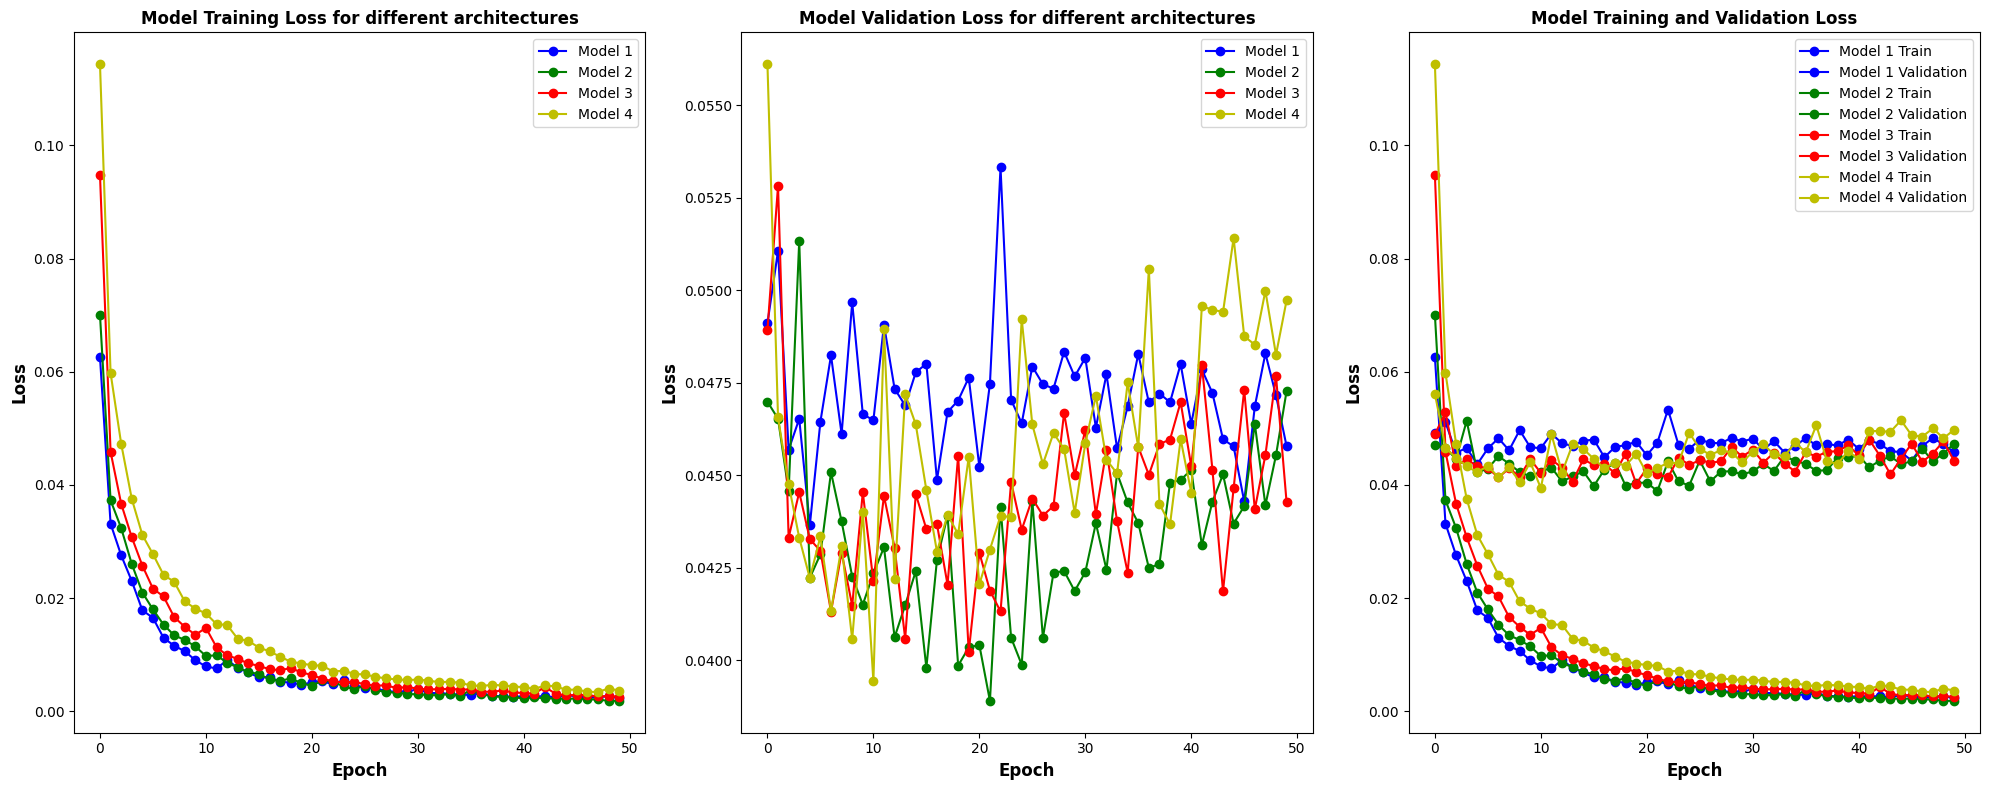

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [28]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_amz_2.pdf")
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")


### Hyperparameter Tuning / Grid Search

In [29]:
import itertools

# Grid Search Parameters
n_layers = [2, 3, 6]
n_nodes = [512, 1024]
optimizer = ['adam', 'sgd', 'rmsprop']
epochs = [50, 100]
learning_rate = [0.001, 0.01, 0.1]
batch_size = [64, 128]
print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs = combination

        # Train the model
        model, history = train_model_2(n_layer, n_node, opt, epoch, lr, bs, train_x, train_y, train_plot=False, seed=10, text_embedding_dim = 512)

        # Evaluate the model
        loss = history.history['val_loss'][-1]  # Considering only the last value

        # Check if this model is better than the previous best
        if best_score is None or loss < best_score:
            best_score = loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y)
print(f"Best Parameters: {best_params}")

Number of combinations: 216
Epoch 1/50
102/102 [==============================] - 3s 19ms/step - loss: 0.0683 - val_loss: 0.0468
Epoch 2/50
102/102 [==============================] - 2s 15ms/step - loss: 0.0336 - val_loss: 0.0489
Epoch 3/50
102/102 [==============================] - 1s 15ms/step - loss: 0.0295 - val_loss: 0.0483
Epoch 4/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0232 - val_loss: 0.0557
Epoch 5/50
102/102 [==============================] - 2s 15ms/step - loss: 0.0217 - val_loss: 0.0435
Epoch 6/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0163 - val_loss: 0.0498
Epoch 7/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0147 - val_loss: 0.0453
Epoch 8/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0133 - val_loss: 0.0529
Epoch 9/50
102/102 [==============================] - 1s 14ms/step - loss: 0.0118 - val_loss: 0.0576
Epoch 10/50
102/102 [==============================] - 2s 16ms/

KeyboardInterrupt: 

In [ ]:
# suppose model 1 is best
n_layers = 2
n_nodes = 512
optimizer = 'adam'
epochs = 50
learning_rate = 0.001
batch_size = 64

best_params = (n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size)

In [ ]:
# fit best model 
best_model, history = train_model_2(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], train_x=train_x, train_y=train_y, text_embedding_dim = 512, train_plot=True)

### Evaluation

In [ ]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 2:]])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_2.csv", index=False)


## Model 3: Ratings + Reviews + Sentiments 

In [31]:
# load data
amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set2_data_modelling.csv')
display(amz_data.head())

# shorten
amz_data = amz_data.iloc[0:10000, :]

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,A14638TGYH7GD9,2010-10-28,0321719816,5.0,even though i use dreamweaver a great deal and...,even though use dreamweav great deal sever boo...,even though use dreamweaver great deal several...,even though use dreamweaver great deal several...,20,11,0.9900
1,A2JMJVNTBL7K7E,2011-04-07,0321719816,5.0,i spent several hours on the lesson and i love...,spent sever hour lesson love detail clear inst...,spent several hour lesson love detailed clear ...,spent several hours lesson love detailed clear...,19,8,0.9766
2,A2BVNVJOFXGZUB,2010-09-26,0321719816,5.0,the video is wellpaced and delivered in an und...,video wellpac deliv understand manner allow wo...,video wellpaced delivered understandable manne...,video wellpaced delivered understandable manne...,3,3,0.4939
3,A14JBDSWKPKTZA,2011-01-08,0321719816,5.0,i have had dreamweaver mx2004 since it came ou...,dreamweav mx2004 sinc came back spent year fee...,dreamweaver mx2004 since came back spent year ...,dreamweaver mx2004 since came back spent years...,12,13,0.9890
4,ACJT8MUC0LRF0,2010-10-16,0321719816,5.0,if youve been wanting to learn how to create y...,youv want learn creat websit either lack confi...,youve wanting learn create website either lack...,youve wanting learn create website either lack...,39,18,0.9995


Number of Rows:  10000
Number of Columns:  11
Number of Unique Users:  2816
Number of Unique Products:  517


User-Item Matrix


asin,0321719816,0763855553,076780192X,0767824571,0767827759,0767834739,0768881714,0782010792,0783239408,0788857746,...,B00004TC6E,B00004TCT3,B00004THXH,B00004TNB0,B00004TSXC,B00004TTI6,B00004TUCV,B00004U1R2,B00004U1R3,B00004U4R9
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100JCBNALJFAW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100ZQDV7L8PVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101RMTZ93J1KH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

In [32]:
import tensorflow as tf
import tensorflow_hub as hub

# load the model for sentence embeddings
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
sent_model = hub.load(module_url)
print(f"Module {module_url} loaded")

# Embedding review text
print("Applying the Universal Sentence Encoder on the review text...")
review_text = amz_data['reviewText']  # Replace with your actual column name
text_embeddings = sent_model(review_text)
print("Review text embeddings generated!")
print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# attach embeddings to dataframe
text_embeddings = text_embeddings.numpy()
text_embeddings = pd.DataFrame(text_embeddings)
text_embeddings['revText'] = amz_data['reviewText']
text_embeddings['asin'] = amz_data['asin']
text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

Module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
Applying the Universal Sentence Encoder on the review text...
Review text embeddings generated!
Shape of Text Embeddings: (10000, 512)


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,0.008073,-0.067272,0.054706,0.023007,0.024579,0.050034,-0.065852,0.067248,0.056147,0.062951,...,0.049765,-0.016111,-0.059012,0.024718,-0.051251,-0.011736,0.000867,even though i use dreamweaver a great deal and...,0321719816,A14638TGYH7GD9
1,-0.001283,-0.068478,0.021437,0.039280,0.002183,0.070368,-0.023990,0.078988,0.043503,0.062656,...,0.070095,-0.042620,0.007568,0.004445,-0.045245,-0.036236,0.042330,i spent several hours on the lesson and i love...,0321719816,A2JMJVNTBL7K7E
2,0.038584,-0.082029,0.064245,-0.025187,0.015820,0.072616,-0.034404,0.097009,0.085545,0.039091,...,0.060228,-0.015527,-0.008636,-0.002517,0.010856,0.043800,0.010278,the video is wellpaced and delivered in an und...,0321719816,A2BVNVJOFXGZUB
3,0.031828,-0.067494,0.063483,0.006458,-0.042029,0.037749,-0.045193,0.061837,0.065983,0.055801,...,0.063073,-0.060632,-0.006769,0.019594,0.000966,-0.063385,-0.039714,i have had dreamweaver mx2004 since it came ou...,0321719816,A14JBDSWKPKTZA


#### Sentiment Scores

In [40]:
sentiments = amz_data[['reviewerID', 'asin','sentiments_vader']]
sentiments.columns = ['reviewerID', 'asin', 'sentiments']
display(sentiments.head(3))

,reviewerID,asin,sentiments
0,A14638TGYH7GD9,0321719816,0.9900
1,A2JMJVNTBL7K7E,0321719816,0.9766
2,A2BVNVJOFXGZUB,0321719816,0.4939


In [41]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 1

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# add sentiments
data_hidden = pd.merge(data_hidden, sentiments, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, sentiments, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,sentiments,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
2971,A16QODENBJVUI1,0763855553,5.0,0.9871,-0.025630,-0.061428,-0.050270,0.056115,0.025042,-0.006502,...,-0.056834,-0.061576,-0.000995,-0.040687,-0.053835,0.002773,-0.000159,0.001383,-0.061306,0.046232
3124,A1EMDSTJDUE6B0,0763855553,3.0,-0.4410,0.043199,-0.048677,-0.039383,0.034834,0.015199,-0.010999,...,0.032779,-0.063053,-0.046424,0.007785,0.073428,0.021332,-0.020626,-0.018779,-0.039079,0.050754
3179,A1GQRGB8FGSLIZ,0763855553,3.0,0.9923,-0.055504,-0.059009,-0.042365,0.010823,0.032200,0.022924,...,-0.058867,-0.059034,0.050042,-0.052651,-0.059034,-0.012173,0.047237,0.055649,-0.057172,0.051605
4491,A376OJHLE6SU9Q,0763855553,4.0,0.9753,-0.005793,-0.041129,-0.053105,-0.018533,0.022194,-0.011605,...,-0.073255,-0.080659,-0.023402,-0.030057,-0.077253,-0.040100,-0.011489,0.033571,-0.060586,0.047489


Data is in format: user, product, rating, sentiments, text embeddings.
It is ready to be partitioned into training and testing sets.


#### Train and Test Splits

In [42]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)
train_x


# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]

# add sentiments to the testing data
test_x = pd.merge(test_x, sentiments, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))


Training Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
2971,72,0,0.9871,-0.025630,-0.061428,-0.050270,0.056115,0.025042,-0.006502,0.048127,...,-0.056834,-0.061576,-0.000995,-0.040687,-0.053835,0.002773,-0.000159,0.001383,-0.061306,0.046232
3124,139,0,-0.4410,0.043199,-0.048677,-0.039383,0.034834,0.015199,-0.010999,-0.014935,...,0.032779,-0.063053,-0.046424,0.007785,0.073428,0.021332,-0.020626,-0.018779,-0.039079,0.050754
3179,171,0,0.9923,-0.055504,-0.059009,-0.042365,0.010823,0.032200,0.022924,0.052965,...,-0.058867,-0.059034,0.050042,-0.052651,-0.059034,-0.012173,0.047237,0.055649,-0.057172,0.051605



Testing Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,98,0,0.9900,0.008073,-0.067272,0.054706,0.023007,0.024579,0.050034,-0.065852,...,-0.012790,-0.068034,0.021810,0.049765,-0.016111,-0.059012,0.024718,-0.051251,-0.011736,0.000867
1,105,0,0.9890,0.031828,-0.067494,0.063483,0.006458,-0.042029,0.037749,-0.045193,...,-0.056906,-0.067767,-0.027785,0.063073,-0.060632,-0.006769,0.019594,0.000966,-0.063385,-0.039714
2,1040,0,0.4939,0.038584,-0.082029,0.064245,-0.025187,0.015820,0.072616,-0.034404,...,0.039041,-0.095472,-0.040151,0.060228,-0.015527,-0.008636,-0.002517,0.010856,0.043800,0.010278


#### NCF Model with Reviews + Sentiments

In [47]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_3(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 
    sentiment_input = Input(shape=(1,), dtype='float32', name='sentiment_input')  # Sentiment scores

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, text_input, sentiment_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, text_input, sentiment_input], outputs=y)
    # ...
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 3:], train_x['sentiments']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_3.pdf")
        plt.show()
    
    return model, history


In [ ]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_3(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512,  seed=10, train_plot=False)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model2, history2 = train_model_3(n_layers=3, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

# Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model3, history3 = train_model_3(n_layers=4, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

# Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model4, history4 = train_model_3(n_layers=5, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, text_embedding_dim = 512, seed=10, train_plot=False)

#### Training Results

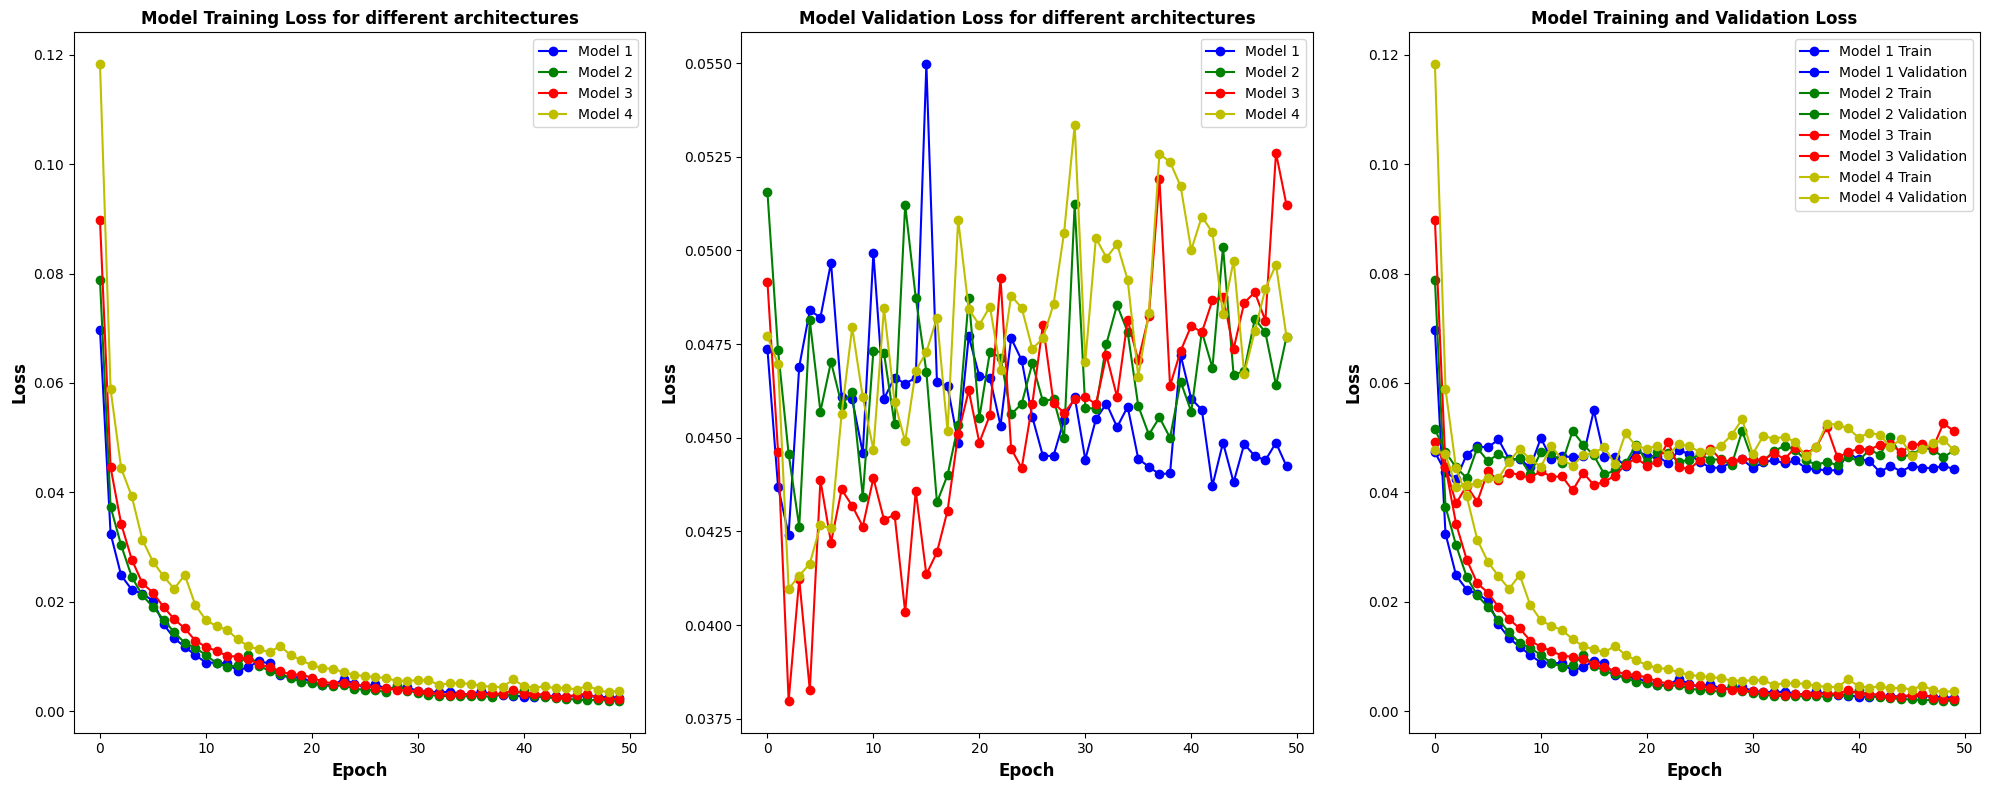

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [49]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_amz_3.pdf")
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")

#### Hyperparamaeter Tuning

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [2, 3, 6]
n_nodes = [512, 1024]
optimizer = ['adam', 'sgd', 'rmsprop']
epochs = [50, 100]
learning_rate = [0.001, 0.01, 0.1]
batch_size = [64, 128]
print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs = combination

        # Train the model
        model, history = train_model_2(n_layer, n_node, opt, epoch, lr, bs, train_x, train_y, train_plot=False, seed=10, text_embedding_dim = 512)

        # Evaluate the model
        loss = history.history['val_loss'][-1]  # Considering only the last value

        # Check if this model is better than the previous best
        if best_score is None or loss < best_score:
            best_score = loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y)
print(f"Best Parameters: {best_params}")

In [ ]:
# suppose model 1 is best
n_layers = 2
n_nodes = 512
optimizer = 'adam'
epochs = 50
learning_rate = 0.001
batch_size = 64

best_params = (n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size)

In [ ]:
# fit best model 
best_model, history = train_model_3(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], train_x=train_x, train_y=train_y, text_embedding_dim = 512, train_plot=True)

In [ ]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 3:], test_x['sentiments']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_3.csv", index=False)


## Benchmarking Recommender Model

We want to build a **naive benchmark model to compare with our NCF model**. The benchmark model will predict the rating of a user-item pair as:

1. the most popular rating in the training set. For example, if the most popular rating in the training set is 4, then the benchmark model will predict the rating of all user-item pairs as 4.

***TLDR***: The benchmark model, which predicts a constant value (5) for all ratings, outperforms the NCF model in terms of rating metrics and some classification metrics. The NCF model, while providing reasonable results, might need further optimization or tuning to improve its performance, especially in terms of rating prediction.


In [55]:
# Benchmark Model 1 (make it all 5s) ====================================
benchmark_results_1 = predicted_ratings_array.copy()
benchmark_results_1.fill(5)

In [52]:
# evaluate benchmark model 1 ====================================
predicted_ratings_array = benchmark_results_1

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)

# Classification predictions
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)
print("\nClassification Metrics")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Rating Metrics
Mean Absolute Error (MAE): 0.64214463840399
Mean Squared Error (MSE): 1.3054862842892767
Root Mean Squared Error (RMSE): 1.1425787869067396

Classification Metrics
Accuracy: 0.8478802992518704
Precision: 0.8478802992518704
Recall: 1.0
F1 Score: 0.9176788124156545


***
# Example

This is a basic implementation of the NCF model. For more advanced features (like adding more layers to the model or using different activation functions), you might need to modify the code accordingly. Also, remember to handle overfitting and underfitting by tuning your model and using techniques like early stopping, regularization, etc.

The code below will train a NCF model on your data and then use it to predict the ratings. The predicted ratings will be stored in the y_pred variable. You can adjust the parameters of the model (such as the number of epochs, the batch size, and the dimensions of the embedding layers) to better fit your data



In [379]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

# tensorflow libraries
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [380]:
# get original data
data = pd.read_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data.csv", index_col=0)
print("Original Data:")
display(data)

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'book', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index
print("Indices of Hidden Ratings:", indices_hidden)

# check hidden data
print("\n\nHidden Data:")
display(data_hidden)

Original Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,4,3,4,4,4,4
user2,4,0,3,5,0,0,0,0,0,4
user3,0,3,4,4,0,2,0,0,0,0
user4,0,0,3,5,4,0,0,0,0,0
user5,3,4,0,4,4,0,5,5,5,5
user6,4,5,0,0,0,0,4,2,2,0
user7,2,2,0,0,0,0,5,3,3,3
user8,0,5,4,0,4,3,0,0,0,0
user9,0,5,4,0,5,2,0,2,2,0
user10,0,0,0,0,5,0,4,4,4,4


Indices of Hidden Ratings: Index([ 10,  14,  16,  17,  19,  20,  23,  27,  34,  37,  48,  51,  57,  60,
        62,  67,  81,  92,  95, 101, 102, 109, 112, 114],
      dtype='int64')


Hidden Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,Hidden,Hidden,4,4,4,4
user2,4,0,3,Hidden,0,0,0,0,0,Hidden
user3,0,Hidden,4,4,0,Hidden,0,0,0,0
user4,0,0,Hidden,5,Hidden,0,0,0,0,0
user5,3,Hidden,0,4,4,0,5,5,5,Hidden
user6,4,Hidden,0,0,0,0,4,2,Hidden,0
user7,2,2,0,0,0,0,5,3,Hidden,Hidden
user8,0,Hidden,4,0,4,Hidden,0,0,0,0
user9,0,Hidden,4,0,5,2,0,Hidden,2,0
user10,0,0,0,0,Hidden,0,Hidden,4,4,4


In [381]:
# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='book', value_name='rating')

# change rows with hidden ratings to 0
data_hidden.iloc[indices_hidden, 2] = 0

print("Melted Data:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden.csv")

Melted Data:


,index,book,rating
0,user1,book1,0
1,user2,book1,4
2,user3,book1,0
3,user4,book1,0
4,user5,book1,3
...,...,...,...
115,user8,book10,0
116,user9,book10,0
117,user10,book10,4
118,user11,book10,0


In [382]:
# rename columns
data_hidden.columns = ['user', 'book', 'rating']

# Filter out the rows where rating is 0
data_hidden = data_hidden[data_hidden['rating'] != 0]
print("Training Data with Hidden Ratings and Non-Zero Ratings:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden_zeros.csv")

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['book'] = data_hidden['book'].astype('category')

Training Data with Hidden Ratings and Non-Zero Ratings:


,user,book,rating
1,user2,book1,4
4,user5,book1,3
5,user6,book1,4
6,user7,book1,2
11,user12,book1,5
18,user7,book2,2
22,user11,book2,2
24,user1,book3,2
25,user2,book3,3
26,user3,book3,4


In [383]:
# Create user and book embedding layers
user_input = Input(shape=(1,), dtype='int32', name='user_input')
book_input = Input(shape=(1,), dtype='int32', name='book_input')

user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
book_embedding = Embedding(input_dim=len(data_hidden['book'].cat.categories), output_dim=50, name='book_embedding')(book_input)

# Flatten the embedding vectors
user_vecs = Flatten()(user_embedding)
book_vecs = Flatten()(book_embedding)

# Concatenate the embedding vectors
input_vecs = Concatenate()([user_vecs, book_vecs])

# Add dense layers
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
y = Dense(1)(x)

# Compile the model
model = Model(inputs=[user_input, book_input], outputs=y)
model.compile(optimizer=Adam(0.001), loss='mse')

# Prepare the data - trining
X = data_hidden[['user', 'book']].apply(lambda x: x.cat.codes)
y = data_hidden['rating'].astype(np.float64)
y = (y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='book', value_name='rating')
copy.columns = ['user', 'book', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['book'] = test_x['book'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4



In [384]:
# see training X and y
print("Training X:")
display(X)

print("Training y:")
display(y)

# save
X.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_X.csv")
y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_y.csv")

Training X:


,user,book
1,4,0
4,7,0
5,8,0
6,9,0
11,3,0
18,9,2
22,2,2
24,0,3
25,4,3
26,5,3


Training y:


1      0.75
4      0.50
5      0.75
6      0.25
11     1.00
18     0.25
22     0.25
24     0.25
25     0.50
26     0.75
31     0.75
32     0.75
35     0.50
36     1.00
38     0.75
39     1.00
40     0.75
52     0.75
55     0.75
56     1.00
58     1.00
59     0.25
68     0.25
71     0.50
72     0.75
76     1.00
77     0.75
78     1.00
82     1.00
83     0.50
84     0.75
88     1.00
89     0.25
90     0.50
93     0.75
94     1.00
96     0.75
100    1.00
104    0.25
105    0.75
106    1.00
107    0.50
108    0.75
117    0.75
Name: rating, dtype: float64

In [385]:
# see training X and y
print("Testing X:")
display(test_x)

print("Testing y:")
display(test_y)

# save
test_x.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_X.csv")
test_y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_Y.csv")

Testing X:


,user,book
10,2,0
14,5,2
16,7,2
17,8,2
19,10,2
20,11,2
23,3,2
27,6,3
34,2,3
37,4,4


Testing y:


10     0.75
14     0.50
16     0.75
17     1.00
19     1.00
20     1.00
23     1.00
27     0.50
34     0.25
37     1.00
48     0.75
51     0.75
57     1.00
60     0.50
62     0.25
67     0.50
81     0.75
92     0.25
95     0.50
101    0.25
102    0.50
109    0.75
112    1.00
114    0.50
Name: rating, dtype: float64

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.5635 - val_loss: 0.5655
Epoch 2/50
1/1 [==============================] - 0s 58ms/step - loss: 0.5340 - val_loss: 0.5412
Epoch 3/50
1/1 [==============================] - 0s 43ms/step - loss: 0.5073 - val_loss: 0.5193
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 0.4846 - val_loss: 0.4973
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 0.4566 - val_loss: 0.4757
Epoch 6/50
1/1 [==============================] - 0s 53ms/step - loss: 0.4403 - val_loss: 0.4543
Epoch 7/50
1/1 [==============================] - 0s 47ms/step - loss: 0.4254 - val_loss: 0.4319
Epoch 8/50
1/1 [==============================] - 0s 50ms/step - loss: 0.3936 - val_loss: 0.4089
Epoch 9/50
1/1 [==============================] - 0s 50ms/step - loss: 0.3797 - val_loss: 0.3854
Epoch 10/50
1/1 [==============================] - 0s 70ms/step - loss: 0.3592 - val_loss: 0.3613
Epoch 11/50
1/1 [==============

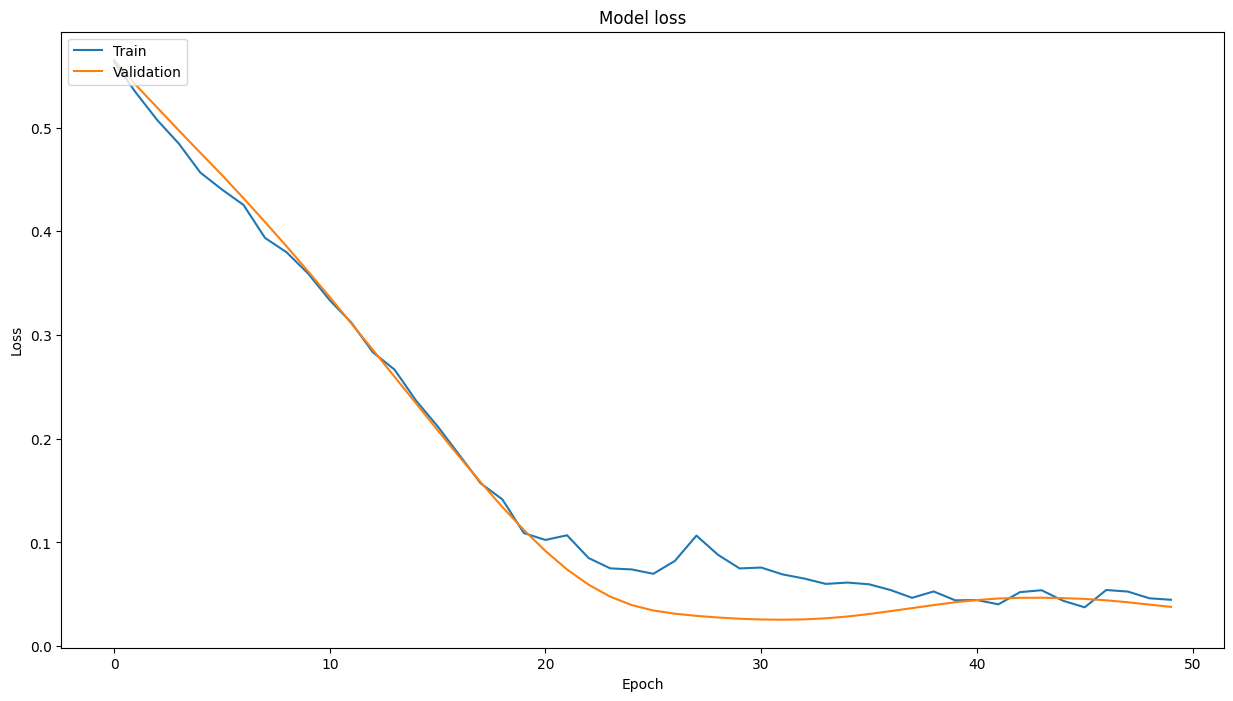

In [386]:
# Train the model
history = model.fit([X['user'], X['book']], y, batch_size=64, epochs=50, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [387]:
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['book']])

# Rescale the predictions back to the 1 - 5 range
y_pred = y_pred * 4 + 1

# see predictions
print("Predictions:")
display(y_pred)

# save
pd.DataFrame(y_pred).to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_y_pred.csv")

1/1 [==============================] - 0s 167ms/step
Predictions:


array([[4.1393805],
       [2.4230828],
       [2.4972453],
       [1.6612036],
       [2.4073176],
       [2.1226764],
       [1.9409723],
       [3.242445 ],
       [3.7316537],
       [4.0426974],
       [3.5080423],
       [3.9258206],
       [3.6982021],
       [2.6096811],
       [2.9007297],
       [2.9094064],
       [4.2280955],
       [3.4573026],
       [3.1991434],
       [2.9439116],
       [3.015808 ],
       [2.9595542],
       [3.5647516],
       [2.6196575]], dtype=float32)

In [389]:
# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# see
print("Hidden Ratings:")
display(hidden_ratings_array)

print("Predicted Ratings:")
display(predicted_ratings_array)

Hidden Ratings:


array([4., 3., 4., 5., 5., 5., 5., 3., 2., 5., 4., 4., 5., 3., 2., 3., 4.,
       2., 3., 2., 3., 4., 5., 3.])

Predicted Ratings:


array([4.1393805, 2.4230828, 2.4972453, 1.6612036, 2.4073176, 2.1226764,
       1.9409723, 3.242445 , 3.7316537, 4.0426974, 3.5080423, 3.9258206,
       3.6982021, 2.6096811, 2.9007297, 2.9094064, 4.2280955, 3.4573026,
       3.1991434, 2.9439116, 3.015808 , 2.9595542, 3.5647516, 2.6196575],
      dtype=float32)

In [390]:
# calculate MAE, MSE and RMSE (take the hidden ratings as the true values and the predicted ratings as the predicted values) ==========================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate MAE, MSE and RMSE
print("Using sklearn")
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Manually
print("\n\nManually")
mae = np.mean(np.abs(hidden_ratings_array - predicted_ratings_array)) # Calculate Mean Absolute Error (MAE)
mse = np.mean((hidden_ratings_array - predicted_ratings_array) ** 2) # Calculate Mean Squared Error (MSE)
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error (RMSE)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Using sklearn
Mean Absolute Error (MAE): 1.0820066034793854
Mean Squared Error (MSE): 2.141600107994963
Root Mean Squared Error (RMSE): 1.4634206872922644


Manually
Mean Absolute Error (MAE): 1.0820066034793854
Mean Squared Error (MSE): 2.141600107994963
Root Mean Squared Error (RMSE): 1.4634206872922644


In [391]:
# step 4: calculate Classification Metrics (take the hidden ratings and the predicted ratings and binarise them) ==========================================================================

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
print(f"If predicted rating is greater than or equal to {threshold}, then 1, else 0\n")
print("Predicted Ratings:", predicted_ratings_array)
print("Binary Predictions:", binary_prediction_ratings)
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)
print("\n")

print("Hidden Ratings:", hidden_ratings_array)
print("Binary Hidden Ratings:", binary_hidden_ratings)

If predicted rating is greater than or equal to 3.5, then 1, else 0

Predicted Ratings: [4.1393805 2.4230828 2.4972453 1.6612036 2.4073176 2.1226764 1.9409723
 3.242445  3.7316537 4.0426974 3.5080423 3.9258206 3.6982021 2.6096811
 2.9007297 2.9094064 4.2280955 3.4573026 3.1991434 2.9439116 3.015808
 2.9595542 3.5647516 2.6196575]
Binary Predictions: [1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0]


Hidden Ratings: [4. 3. 4. 5. 5. 5. 5. 3. 2. 5. 4. 4. 5. 3. 2. 3. 4. 2. 3. 2. 3. 4. 5. 3.]
Binary Hidden Ratings: [1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0]


In [392]:
# calculate accuracy using sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# calculate accuracy using sklearn
print("Using sklearn")
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# calculate accuracy manually
print("\n\nManually")
true_positives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 1))
true_negatives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 0))
false_positives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 1))
false_negatives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 0))

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Using sklearn
Accuracy: 0.7083333333333334
Precision: 0.875
Recall: 0.5384615384615384
F1 Score: 0.6666666666666667


Manually
Accuracy: 0.7083333333333334
Precision: 0.875
Recall: 0.5384615384615384
F1 Score: 0.6666666666666667


### Hyperparameter Tuning

Experimenting with different parameters and visualizing the training process can provide valuable insights into how well our model is performing and where improvements can be made.

- ***Plot Training and Validation Loss:*** This can help you understand if your model is overfitting or underfitting. If your training loss is much lower than your validation loss, your model might be overfitting. If both losses are high, your model might be underfitting.

- ***Experiment with Different Architectures:*** Try adding more layers to your model or increasing the number of neurons in each layer. You could also experiment with different types of layers (e.g., convolutional layers, recurrent layers) and different activation functions.

- ***Tune Hyperparameters***: This includes the learning rate, batch size, number of epochs, and regularization parameters. You could use techniques like grid search or random search to systematically explore different combinations of hyperparameters.

- ***Use Early Stopping:*** This technique allows you to stop training once the model’s performance on a validation set stops improving, which can be useful to prevent overfitting.

- ***Try Different Optimization Algorithms:*** In addition to Adam, there are many other optimization algorithms available in TensorFlow, such as SGD, RMSprop, and Adagrad. Different optimizers might lead to different results.

- ***Regularization:*** If your model is overfitting, you might want to add some form of regularization, such as L1 or L2 regularization, or dropout.

- ***Data Augmentation***: If you have a small dataset, you could artificially increase its size by creating modified versions of your existing data. For example, you could add small amounts of noise to your input data.

- ***Learning Rate Scheduling:*** Instead of using a fixed learning rate, you could decrease it over time or in response to the model’s performance.


In [423]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# tensorflow libraries
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [424]:
# DATA LOADING ====================================

# get original data
data = pd.read_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data.csv", index_col=0)

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'book', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='book', value_name='rating')

# change rows with hidden ratings to 0
data_hidden.iloc[indices_hidden, 2] = 0

# rename columns
data_hidden.columns = ['user', 'book', 'rating']

# Filter out the rows where rating is 0
data_hidden = data_hidden[data_hidden['rating'] != 0]

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['book'] = data_hidden['book'].astype('category')


In [425]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'book']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='book', value_name='rating')
copy.columns = ['user', 'book', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['book'] = test_x['book'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

In [429]:
# Function to train a neural network model for collaborative filtering
def train_model(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, seed=10, train_plot=True):
    """
    Function to train a neural network model for collaborative filtering.
    :param n_layers: Number of dense layers in the model
    :param n_nodes: Number of nodes in each dense layer
    :param optimizer: Optimizer to use for training
    :param epochs: Number of epochs to train for
    :param learning_rate: Learning rate for the optimizer
    :param train_x: Training data
    :param train_y: Training labels
    :param seed: Random seed
    :return: Trained model and training history
    """
    # Set random seed
    np.random.seed(seed)

    # Create user and book embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    book_input = Input(shape=(1,), dtype='int32', name='book_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    book_embedding = Embedding(input_dim=len(data_hidden['book'].cat.categories), output_dim=50, name='book_embedding')(book_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    book_vecs = Flatten()(book_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, book_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, book_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['book']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training.png")
        plt.show()
    
    return model, history

In [456]:
# Train the model
model, history = train_model(n_layers=2, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 2 - 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
model2, history2 = train_model(n_layers=3, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 3 - 2 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size
model3, history3 = train_model(n_layers=2, n_nodes=256, optimizer='sgd', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 4 - 3 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size
model4, history4 = train_model(n_layers=3, n_nodes=256, optimizer='sgd', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 5 - 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
model5, history5 = train_model(n_layers=2, n_nodes=256, optimizer='rmsprop', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 6 - 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
model6, history6 = train_model(n_layers=3, n_nodes=256, optimizer='rmsprop', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 7 - 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
model7, history7 = train_model(n_layers=2, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.01, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 8 - 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
model8, history8 = train_model(n_layers=3, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.01, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5390 - val_loss: 0.5478
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.4867 - val_loss: 0.4995
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.4444 - val_loss: 0.4531
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 0.4011 - val_loss: 0.4081
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 0.3565 - val_loss: 0.3636
Epoch 6/100
1/1 [==============================] - 0s 51ms/step - loss: 0.3172 - val_loss: 0.3195
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2746 - val_loss: 0.2763
Epoch 8/100
1/1 [==============================] - 0s 49ms/step - loss: 0.2299 - val_loss: 0.2332
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1803 - val_loss: 0.1912
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 0.1490 - val_loss: 0.1517
Epoch 11/100
1/1 [===

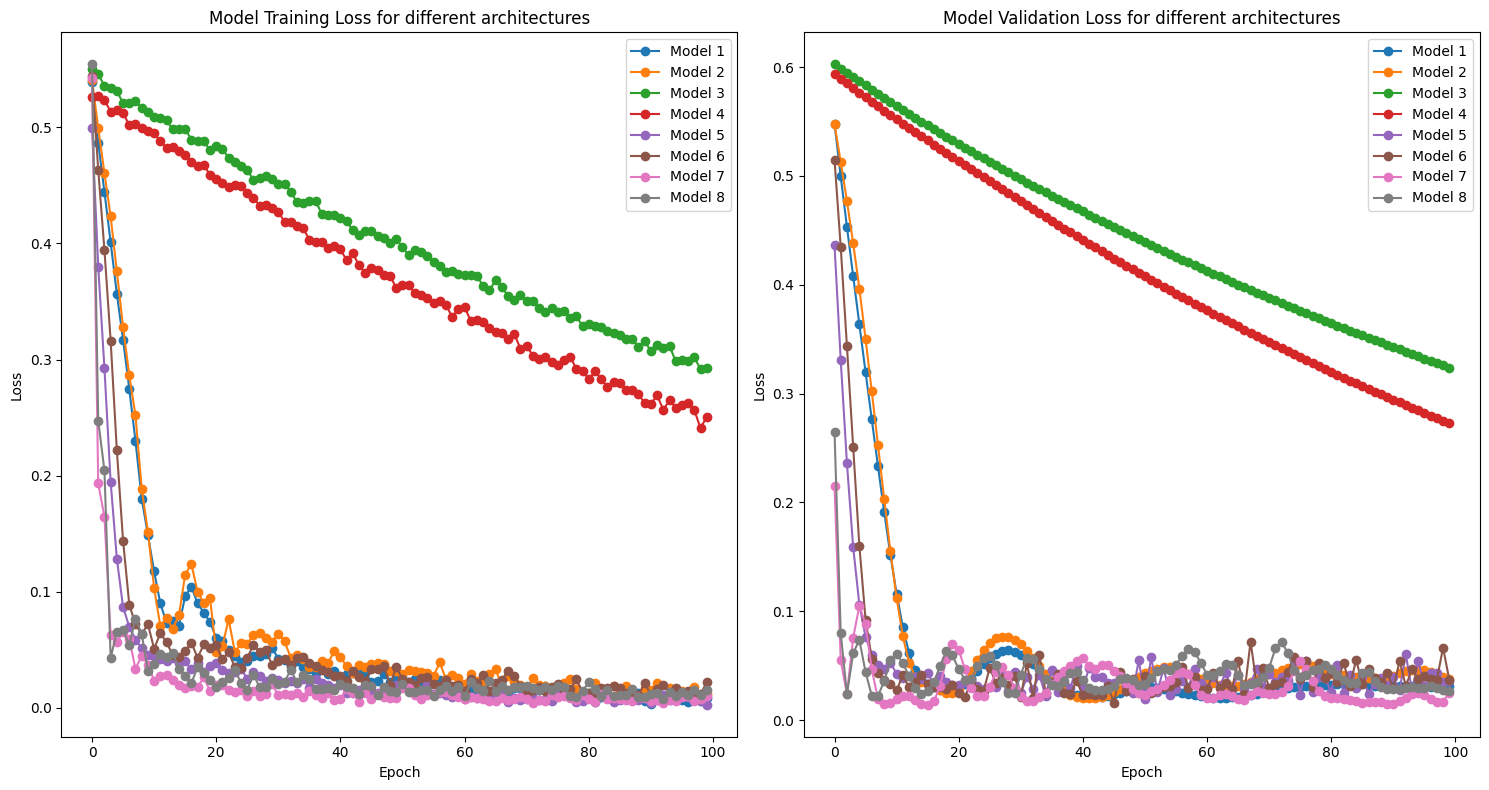

Model 1: 2 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
Model 3: 2 layers, 256 nodes, sgd, 100 epochs, 0.01 learning rate, 64 batch size
Model 4: 3 layers, 256 nodes, sgd, 100 epochs, 0.01 learning rate, 64 batch size
Model 5: 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
Model 6: 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
Model 7: 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
Model 8: 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size


In [457]:
# visualise training and validation loss for all models
plt.figure(figsize=(15, 8))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o')
plt.plot(history2.history['loss'], label='Model 2', marker='o')
plt.plot(history3.history['loss'], label='Model 3', marker='o')
plt.plot(history4.history['loss'], label='Model 4', marker='o')
plt.plot(history5.history['loss'], label='Model 5', marker='o')
plt.plot(history6.history['loss'], label='Model 6', marker='o')
plt.plot(history7.history['loss'], label='Model 7', marker='o')
plt.plot(history8.history['loss'], label='Model 8', marker='o')
plt.title('Model Training Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o')
plt.plot(history5.history['val_loss'], label='Model 5', marker='o')
plt.plot(history6.history['val_loss'], label='Model 6', marker='o')
plt.plot(history7.history['val_loss'], label='Model 7', marker='o')
plt.plot(history8.history['val_loss'], label='Model 8', marker='o')
plt.title('Model Validation Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_all.png")
plt.show()

# print models
print("Model 1: 2 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 2 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 3 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 5: 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 6: 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 7: 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size")
print("Model 8: 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size")


In [ ]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['book']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)

# Classification predictions
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Querying ChatGPT

I am doing a project on building a neural collaborative filtering recommender system using amazon product review data. I want the recommender system to use the user ratings for items and the user review text. I have the following function for NCF using ratings and review text:
def train_model(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, review_text_embeddings, seed=2207):
    np.random.seed(seed)
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input')  # Text embeddings

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    input_vecs = Concatenate()([user_vecs, product_vecs, text_input])

    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_input, product_input, text_input], outputs=y)
    # ...
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    
    return model, history

How does it look?

Now this is the code I have done for preprocessing the ratings that each user has given for each item: x_hidden = data.copy()
indices_tracker = []
N = 3
np.random.seed(2207) 
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    # print("User:", user_id)
    # print("Indices of Rated Products:", rated_products)
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    # print("Indices to Hide:", hidden_indices, "\n")
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')
data_hidden.iloc[indices_hidden, 2] = np.nan
data_hidden.columns = ['user', 'product', 'rating']
data_hidden = data_hidden[data_hidden['rating'].notna()]
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

copy = x.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

How can i adjust this code to also include and preprocess my review text data which is stored in 'data'.